In [14]:
from einops import rearrange
import itertools
import lzma
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.cluster import KMeans
import warnings
warnings.filterwarnings('ignore')

In [15]:
device = torch.device(f"cuda:1" if torch.cuda.is_available() else "cpu")

class MAPDataset(Dataset):
    def __init__(self, df):
        self.past=list(df["past"].values)
        self.future=list(df["future"].values)

    def __getitem__(self, idx):
        past = self.past[idx]
        future = self.future[idx]
        return [past,future]

    def __len__(self):
        return len(self.past)
    
    
    def collate_fn(self, batch):
        past_b = [x[0] for x in batch]
        future_b = [x[1] for x in batch]
#        data=rearrange(past_b, '(b h c) w-> b c h w',c=cf.channels,b=batch,h=cf.image_size[0],w=cf.image_size[1])
#        print(np.array(past_b).shape)

        data=rearrange(np.array(past_b), '(b c) h w-> b c h w',c=1, h=10, w=10)

        past_tensor=torch.Tensor(data).to(device)
        
        future_tensor=torch.Tensor(future_b).to(device)

        
        return past_tensor, future_tensor

In [11]:
def read_load_trace_data(load_trace, num_prefetch_warmup_instructions,num_total_instructions,skipping=0):
    
    def process_line(line):
        split = line.strip().split(', ')
        return int(split[0]), int(split[1]), int(split[2], 16), int(split[3], 16), split[4] == '1'

    train_data = []
    eval_data = []
    if load_trace[-2:] == 'xz':
        with lzma.open(load_trace, 'rt') as f:
            for line in f:
                pline = process_line(line)
                if pline[0]>skipping*1000000:
                    if pline[0] < num_prefetch_warmup_instructions * 1000000:
                        train_data.append(pline)
                    else:
                        if pline[0] < num_total_instructions * 1000000:
                            eval_data.append(pline)
                        else:
                            break
    else:
        with open(load_trace, 'r') as f:
            for line in f:
                pline = process_line(line)
                if pline[0]>skipping*1000000:
                    if pline[0] < num_prefetch_warmup_instructions * 1000000:
                        train_data.append(pline)
                    else:
                        if pline[0] < num_total_instructions * 1000000:
                            eval_data.append(pline)
                        else:
                            break

    return train_data, eval_data

In [62]:
BLOCK_BITS=6
TOTAL_BITS=64
LOOK_BACK=9
PRED_FORWARD=128

BLOCK_NUM_BITS=58
PAGE_BITS=12
BITMAP_SIZE=256
DELTA_BOUND=128
SPLIT_BITS=6
FILTER_SIZE=16
#%%% Interface

def to_bitmap(n,bitmap_size): 
    #l0=np.ones((bitmap_size),dtype = int)
    l0=np.zeros((bitmap_size),dtype = int)
    if(len(n)>0):
        for x in n:
            if x>0:
                l0[int(x)-1]=1
            elif x<0:
                l0[int(x)]=1
        l1=list(l0)
        return l1
    else:
        return list(l0)

def split_to_words(value,BN_bits=58,split_bits=6,norm=True):
    #res=[SPLITER_ID]
    res=[]
    for i in range(BN_bits//split_bits+1):
        divider=2**split_bits
        #res.append(value%(divider)+OFFSET)#add 1, range(1-64),0 as padding
        new_val=value%(divider)
        if norm==True:
            new_val=new_val/divider
        res.append(new_val)#
        value=value//divider
    return res

def delta_acc_list(delta,DELTA_BOUND=128):#delta accumulative list
    res=list(itertools.accumulate(delta))
    res=[i for i in res if abs(i)<=DELTA_BOUND]
    if len(res)==0:
        res="nan"
    return res


def addr_hash(x,HASH_BITS):
    t = int(x)^(int(x)>>32); 
    result = (t^(t>>HASH_BITS)) & (2**HASH_BITS-1); 
    return result/(2**HASH_BITS)

def ip_list_norm(ip_list,HASH_BITS):
    return [addr_hash(ip,HASH_BITS) for ip in ip_list]

def page_list_norm(page_list,current_page):
    return list(1/(abs(np.array(page_list)-current_page)+1))
     
    
def preprocessing(data):
    print("preprocessing with context")
    df=pd.DataFrame(data)
    df.columns=["id", "cycle", "addr", "ip", "hit"]
    df['raw']=df['addr']
    df['block_address'] = [x>>BLOCK_BITS for x in df['raw']]
    df['page_address'] = [ x >> PAGE_BITS for x in df['raw']]
    #df['page_address_str'] = [ "%d" % x for x in df['page_address']]
    df['page_offset'] = [x- (x >> PAGE_BITS<<PAGE_BITS) for x in df['raw']]
    df['block_index'] = [int(x>> BLOCK_BITS) for x in df['page_offset']]  
    #df["block_address_bin"]=df.apply(lambda x: convert_to_binary(x['block_address'],BLOCK_NUM_BITS),axis=1)
    df['block_addr_delta']=df['block_address'].diff()
    
    df['patch']=df.apply(lambda x: split_to_words(x['block_address'],BLOCK_NUM_BITS,SPLIT_BITS),axis=1)
    # past
    for i in range(LOOK_BACK):
        df['delta_past_%d'%(i+1)]=df['block_addr_delta'].shift(periods=(i+1))
        df['block_addr_past_%d'%(i+1)]=df['block_address'].shift(periods=(i+1))
        df['patch_past_%d'%(i+1)]=df['patch'].shift(periods=(i+1))
        df['ip_past_%d'%(i+1)]=df['ip'].shift(periods=(i+1))
        df['page_past_%d'%(i+1)]=df['page_address'].shift(periods=(i+1))
    
    #Pem, update, debug 2019/09/18
    past_addr_name=['block_addr_past_%d'%(i) for i in range(LOOK_BACK,0,-1)]
    past_name=['patch_past_%d'%(i) for i in range(LOOK_BACK,0,-1)]
    past_ip_name=['ip_past_%d'%(i) for i in range(LOOK_BACK,0,-1)]
    past_page_name=['page_past_%d'%(i) for i in range(LOOK_BACK,0,-1)]
    past_delta_name=['delta_past_%d'%(i) for i in range(LOOK_BACK,0,-1)]
    past_name.append('patch')
    past_ip_name.append('ip')
    past_page_name.append('page_address')
    #Pem, update done
    
    df["past"]=df[past_name].values.tolist()
    df['past_block_addr_abs']=df[past_addr_name].values.tolist()
    df["past_ip_abs"]=df[past_ip_name].values.tolist()
    df["past_page_abs"]=df[past_page_name].values.tolist()
    df['past_delta_abs']=df[past_delta_name].values.tolist()
    df=df.dropna()
    df['past_block_addr']=df.apply(lambda x: [item for item in x['past_block_addr_abs'] if pd.notnull(item)], axis=1)
    df['past_delta']=df.apply(lambda x: [item for item in x['past_delta_abs'] if pd.notnull(item)], axis=1)
    df['past_ip']=df.apply(lambda x: ip_list_norm(x['past_ip_abs'],16),axis=1)
    df['past_page']=df.apply(lambda x: page_list_norm(x['past_page_abs'],x['page_address']),axis=1)
    
    #labels
    '''
    future_idx: delta to the prior addr
    future_delta: accumulative delta to current addr
    '''
    for i in range(PRED_FORWARD):
        df['delta_future_%d'%(i+1)]=df['block_addr_delta'].shift(periods=-(i+1))
    
    for i in range(PRED_FORWARD):
            if i==0:
                df["future_idx"]=df[['delta_future_%d'%(i+1)]].values.astype(int).tolist()
            else:   
                df["future_idx"]=np.hstack((df["future_idx"].values.tolist(), df[['delta_future_%d'%(i+1)]].values.astype(int))).tolist()
                
                #df[['delta_future_%d'%(i+1)]].values.tolist()
    
    #delta bitmap
    df["future_delta"]=df.apply(lambda x: delta_acc_list(x['future_idx'],DELTA_BOUND),axis=1)
    
    df=df[df["future_delta"]!="nan"]
    
    df["future"]=df.apply(lambda x: to_bitmap(x['future_delta'],BITMAP_SIZE),axis=1)
    df=df.dropna()
    return df[['id', 'cycle', 'addr', 'ip', 'hit', 'raw', 'block_address',
       'page_address', 'page_offset', 'block_index', 'block_addr_delta',
       'patch','past','past_block_addr','past_ip','past_page','past_delta','future']]

In [17]:
train_data, eval_data = read_load_trace_data('../ML-DPC-S0/LoadTraces/410.bwaves-s0.txt.xz', 3, 5, 1)

df_train= preprocessing(train_data)
df_test = preprocessing(eval_data)

print("Beginning to save data for stu")

data_train = df_train['past_ip'].values
data_train = np.array(data_train.tolist())

data_test = df_test['past_ip'].values
data_test = np.array(data_test.tolist())

kmeans = KMeans(n_clusters=5, init='k-means++', random_state=0, n_init=10)

df_train['cluster'] = kmeans.fit_predict(data_train)
df_test['cluster'] = kmeans.predict(data_test)

preprocessing with context
preprocessing with context
Beginning to save data for stu


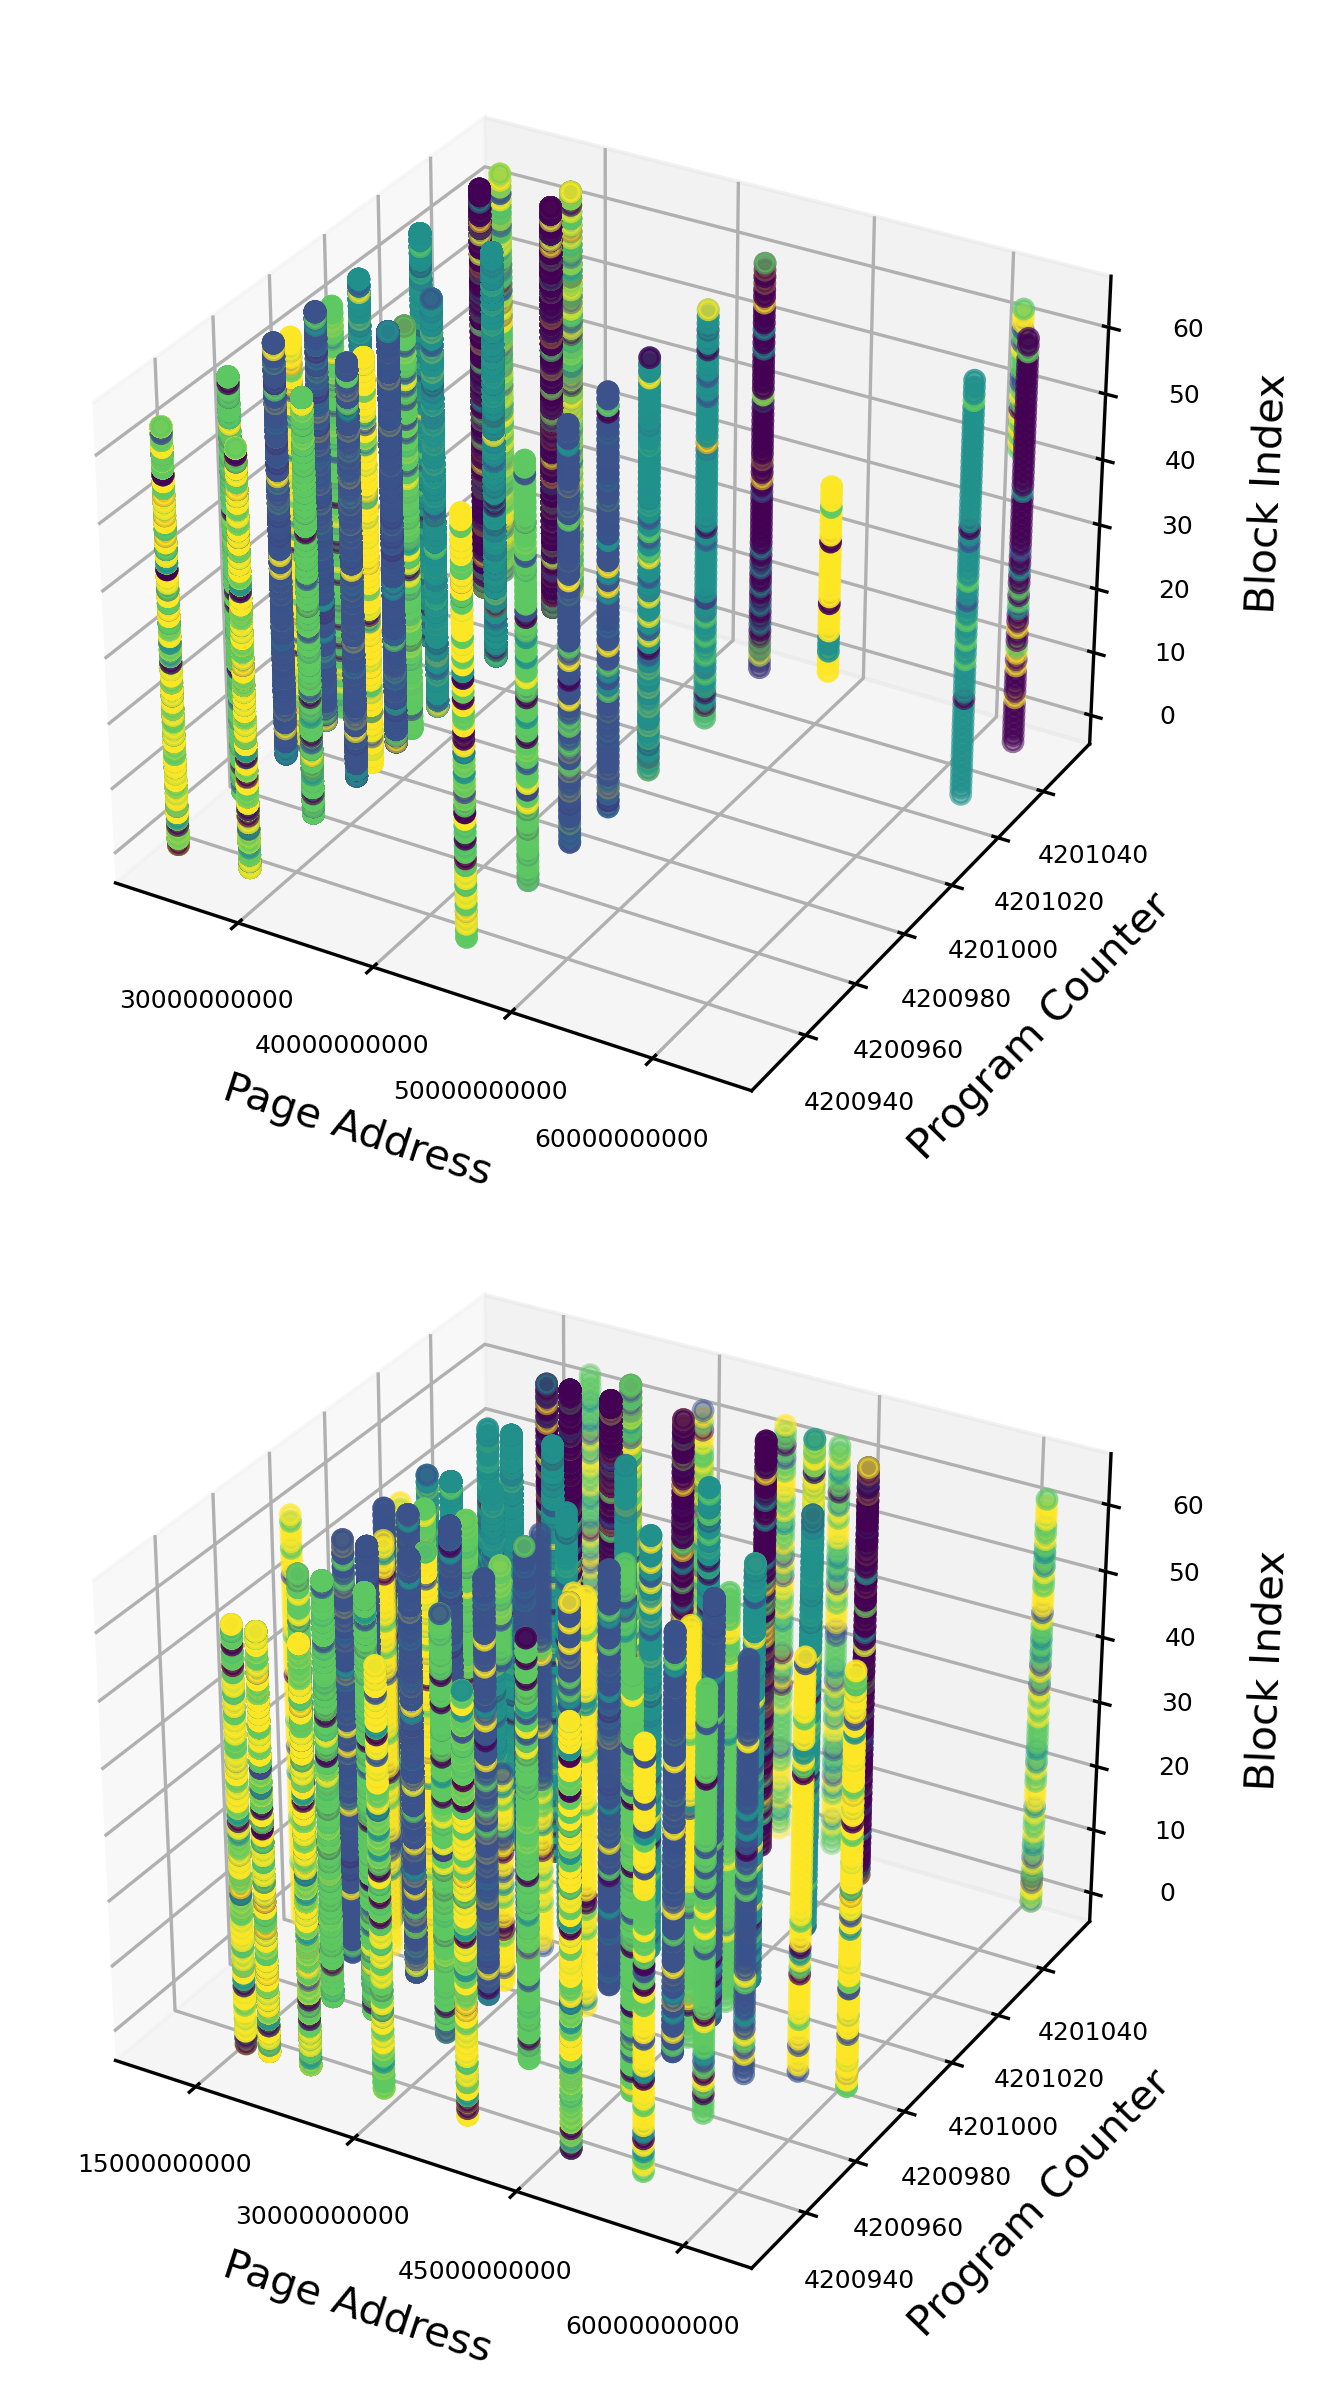

In [67]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import MaxNLocator

fig = plt.figure(figsize=(5, 8), dpi=300)

ax_train = fig.add_subplot(211, projection='3d')
x_train = df_train['page_address']
y_train = df_train['ip']
z_train = df_train['block_index']
c_train = df_train['cluster']

ax_train.scatter3D(x_train, y_train, z_train, c=c_train)

ax_train.set_xlabel('Page Address')
ax_train.set_ylabel('Program Counter')
ax_train.set_zlabel('Block Index')
ax_train.yaxis.set_major_formatter('{:.0f}'.format)
ax_train.xaxis.set_major_formatter('{:.0f}'.format)
ax_train.tick_params(axis='both', which='major', labelsize=6)

ax_test = fig.add_subplot(212, projection='3d')

x_test = df_test['page_address']
y_test = df_test['ip']
z_test = df_test['block_index']
c_test = df_test['cluster']

ax_test.scatter3D(x_test, y_test, z_test, c=c_test)

ax_test.set_xlabel('Page Address')
ax_test.set_ylabel('Program Counter')
ax_test.set_zlabel('Block Index')
ax_test.yaxis.set_major_formatter('{:.0f}'.format)
ax_test.xaxis.set_major_formatter('{:.0f}'.format)
ax_test.tick_params(axis='both', which='major', labelsize=6)

ax_train.xaxis.set_major_locator(MaxNLocator(nbins=5))
ax_test.xaxis.set_major_locator(MaxNLocator(nbins=5))

plt.tight_layout()
plt.savefig('bwaves-past-ip.png', dpi=300)

plt.show()

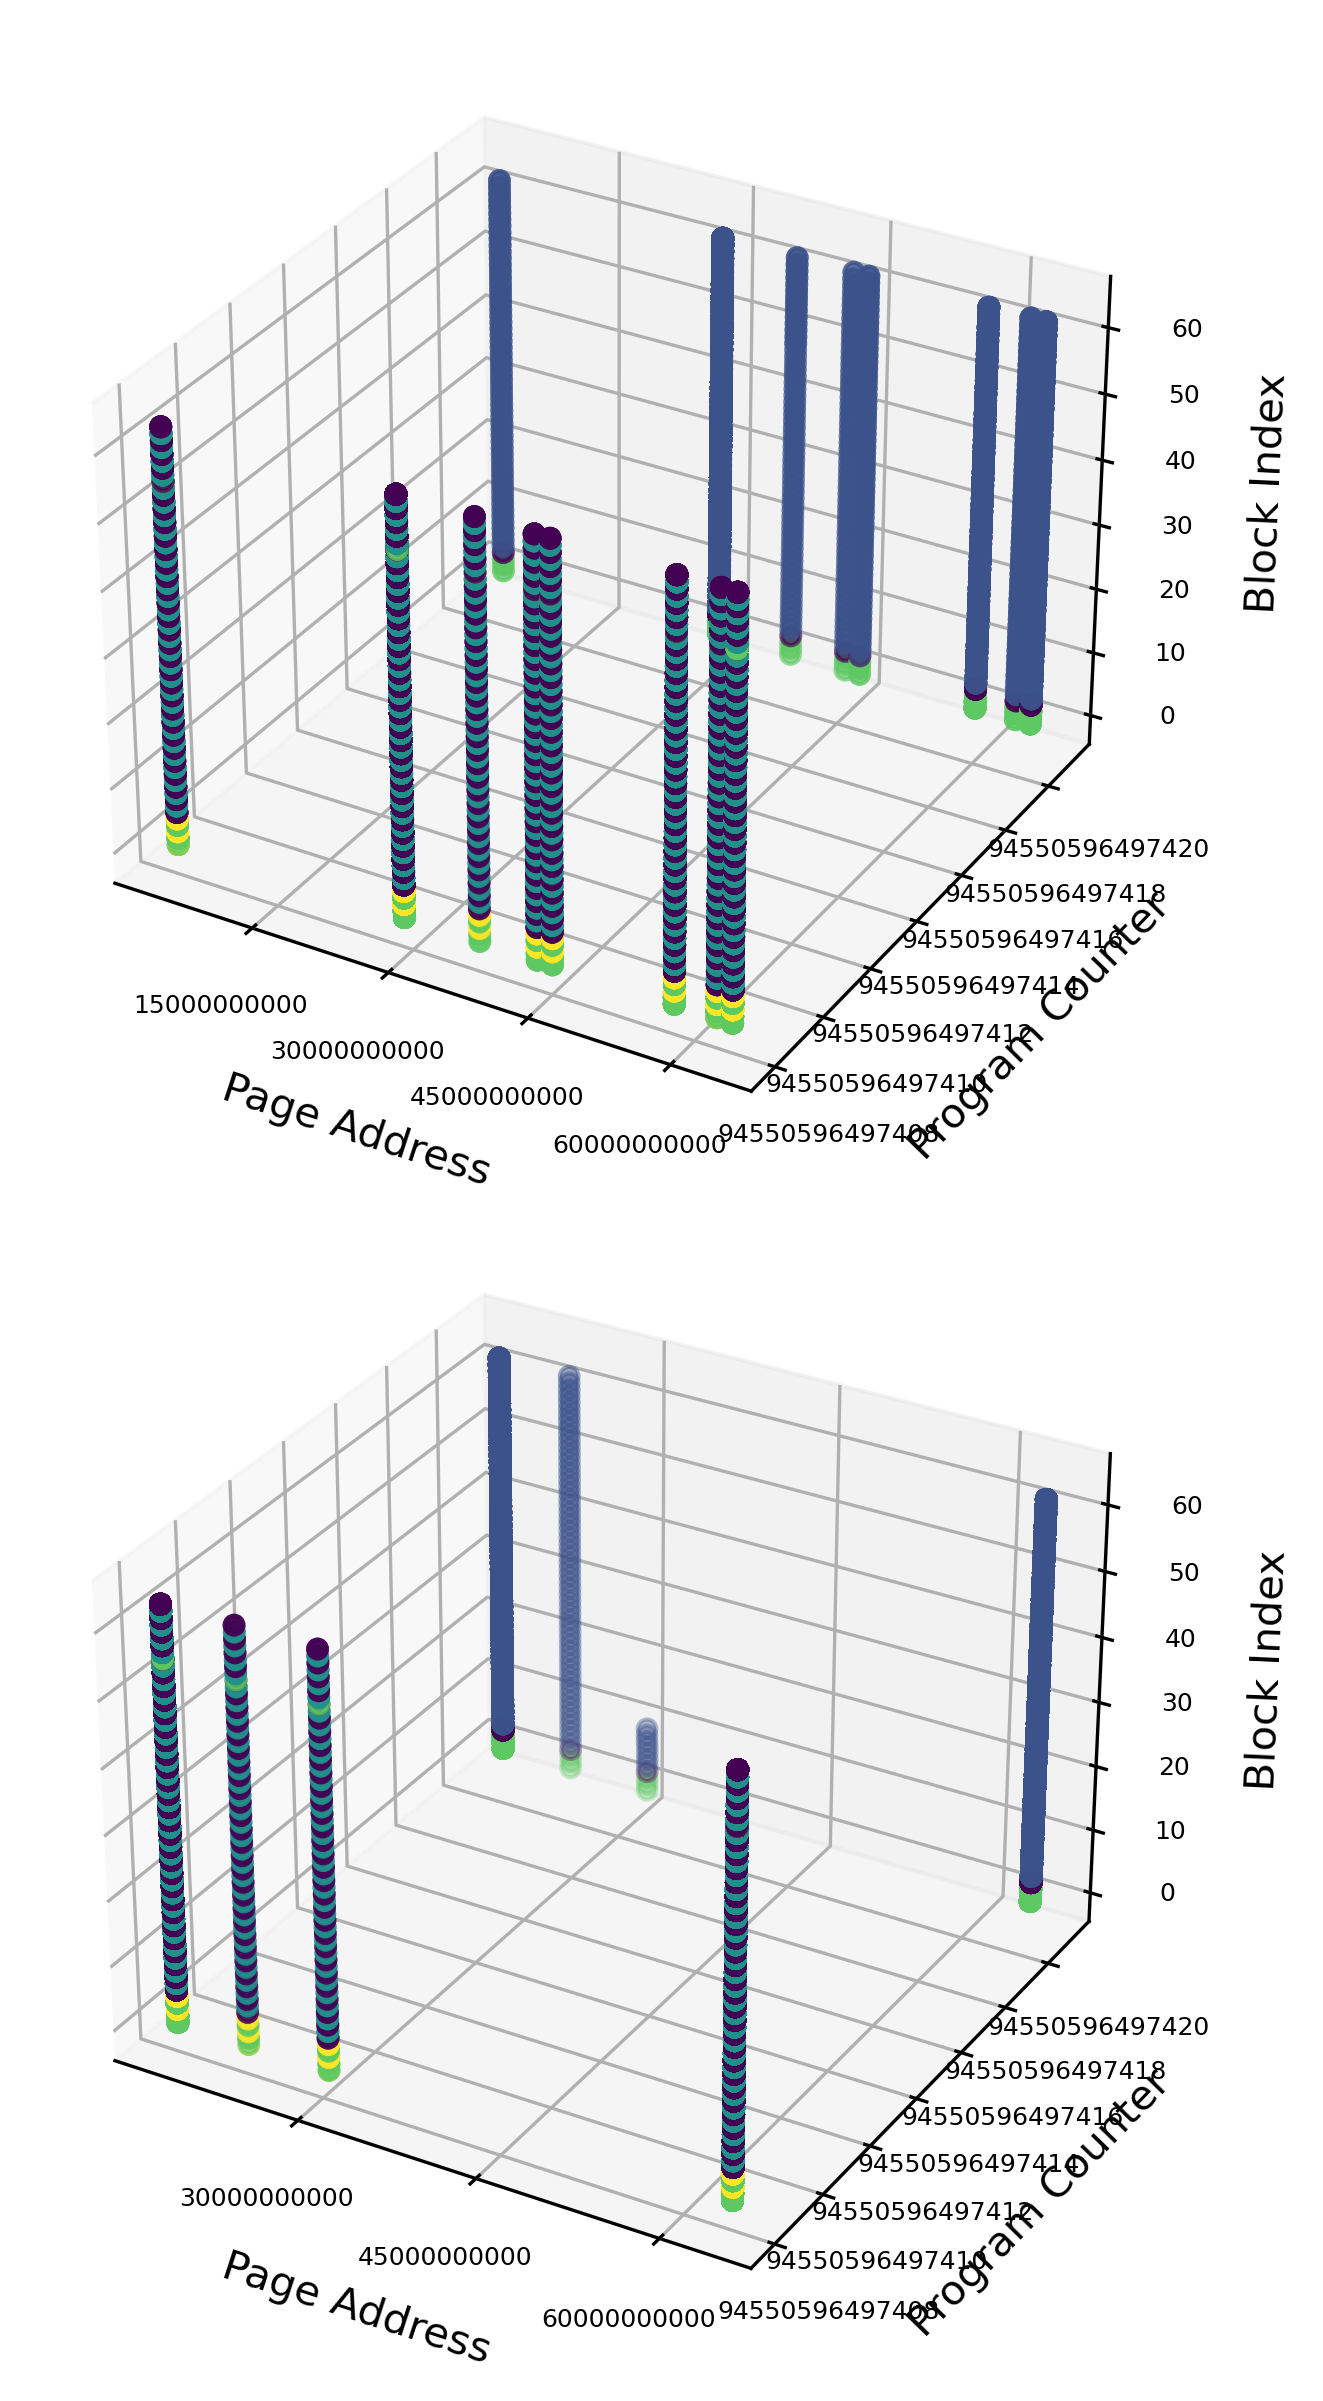

In [73]:
data_train = df_train['past_page'].values
data_train = np.array(data_train.tolist())

data_test = df_test['past_page'].values
data_test = np.array(data_test.tolist())

kmeans = KMeans(n_clusters=5, init='k-means++', random_state=0, n_init=10)

df_train['cluster'] = kmeans.fit_predict(data_train)
df_test['cluster'] = kmeans.predict(data_test)

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import MaxNLocator

fig = plt.figure(figsize=(5, 8), dpi=300)

ax_train = fig.add_subplot(211, projection='3d')
x_train = df_train['page_address']
y_train = df_train['ip']
z_train = df_train['block_index']
c_train = df_train['cluster']

ax_train.scatter3D(x_train, y_train, z_train, c=c_train)

ax_train.set_xlabel('Page Address')
ax_train.set_ylabel('Program Counter')
ax_train.set_zlabel('Block Index')
ax_train.yaxis.set_major_formatter('{:.0f}'.format)
ax_train.xaxis.set_major_formatter('{:.0f}'.format)
ax_train.tick_params(axis='both', which='major', labelsize=6)

ax_test = fig.add_subplot(212, projection='3d')

x_test = df_test['page_address']
y_test = df_test['ip']
z_test = df_test['block_index']
c_test = df_test['cluster']

ax_test.scatter3D(x_test, y_test, z_test, c=c_test)

ax_test.set_xlabel('Page Address')
ax_test.set_ylabel('Program Counter')
ax_test.set_zlabel('Block Index')
ax_test.yaxis.set_major_formatter('{:.0f}'.format)
ax_test.xaxis.set_major_formatter('{:.0f}'.format)
ax_test.tick_params(axis='both', which='major', labelsize=6)

ax_train.xaxis.set_major_locator(MaxNLocator(nbins=5))
ax_test.xaxis.set_major_locator(MaxNLocator(nbins=5))

plt.tight_layout()
plt.savefig('bwaves-past-ip.png', dpi=300)

plt.show()

In [76]:
train_data, eval_data = read_load_trace_data('../ML-DPC-S0/LoadTraces/473.astar-s0.txt.xz', 3, 5, 1)

df_train= preprocessing(train_data)
df_test = preprocessing(eval_data)

print("Beginning to save data for stu")

data_train = df_train['past_delta'].values
data_train = np.array(data_train.tolist())

data_test = df_test['past_delta'].values
data_test = np.array(data_test.tolist())

kmeans = KMeans(n_clusters=5, init='k-means++', random_state=0, n_init=10)

df_train['cluster'] = kmeans.fit_predict(data_train)
df_test['cluster'] = kmeans.predict(data_test)

preprocessing with context


preprocessing with context
Beginning to save data for stu


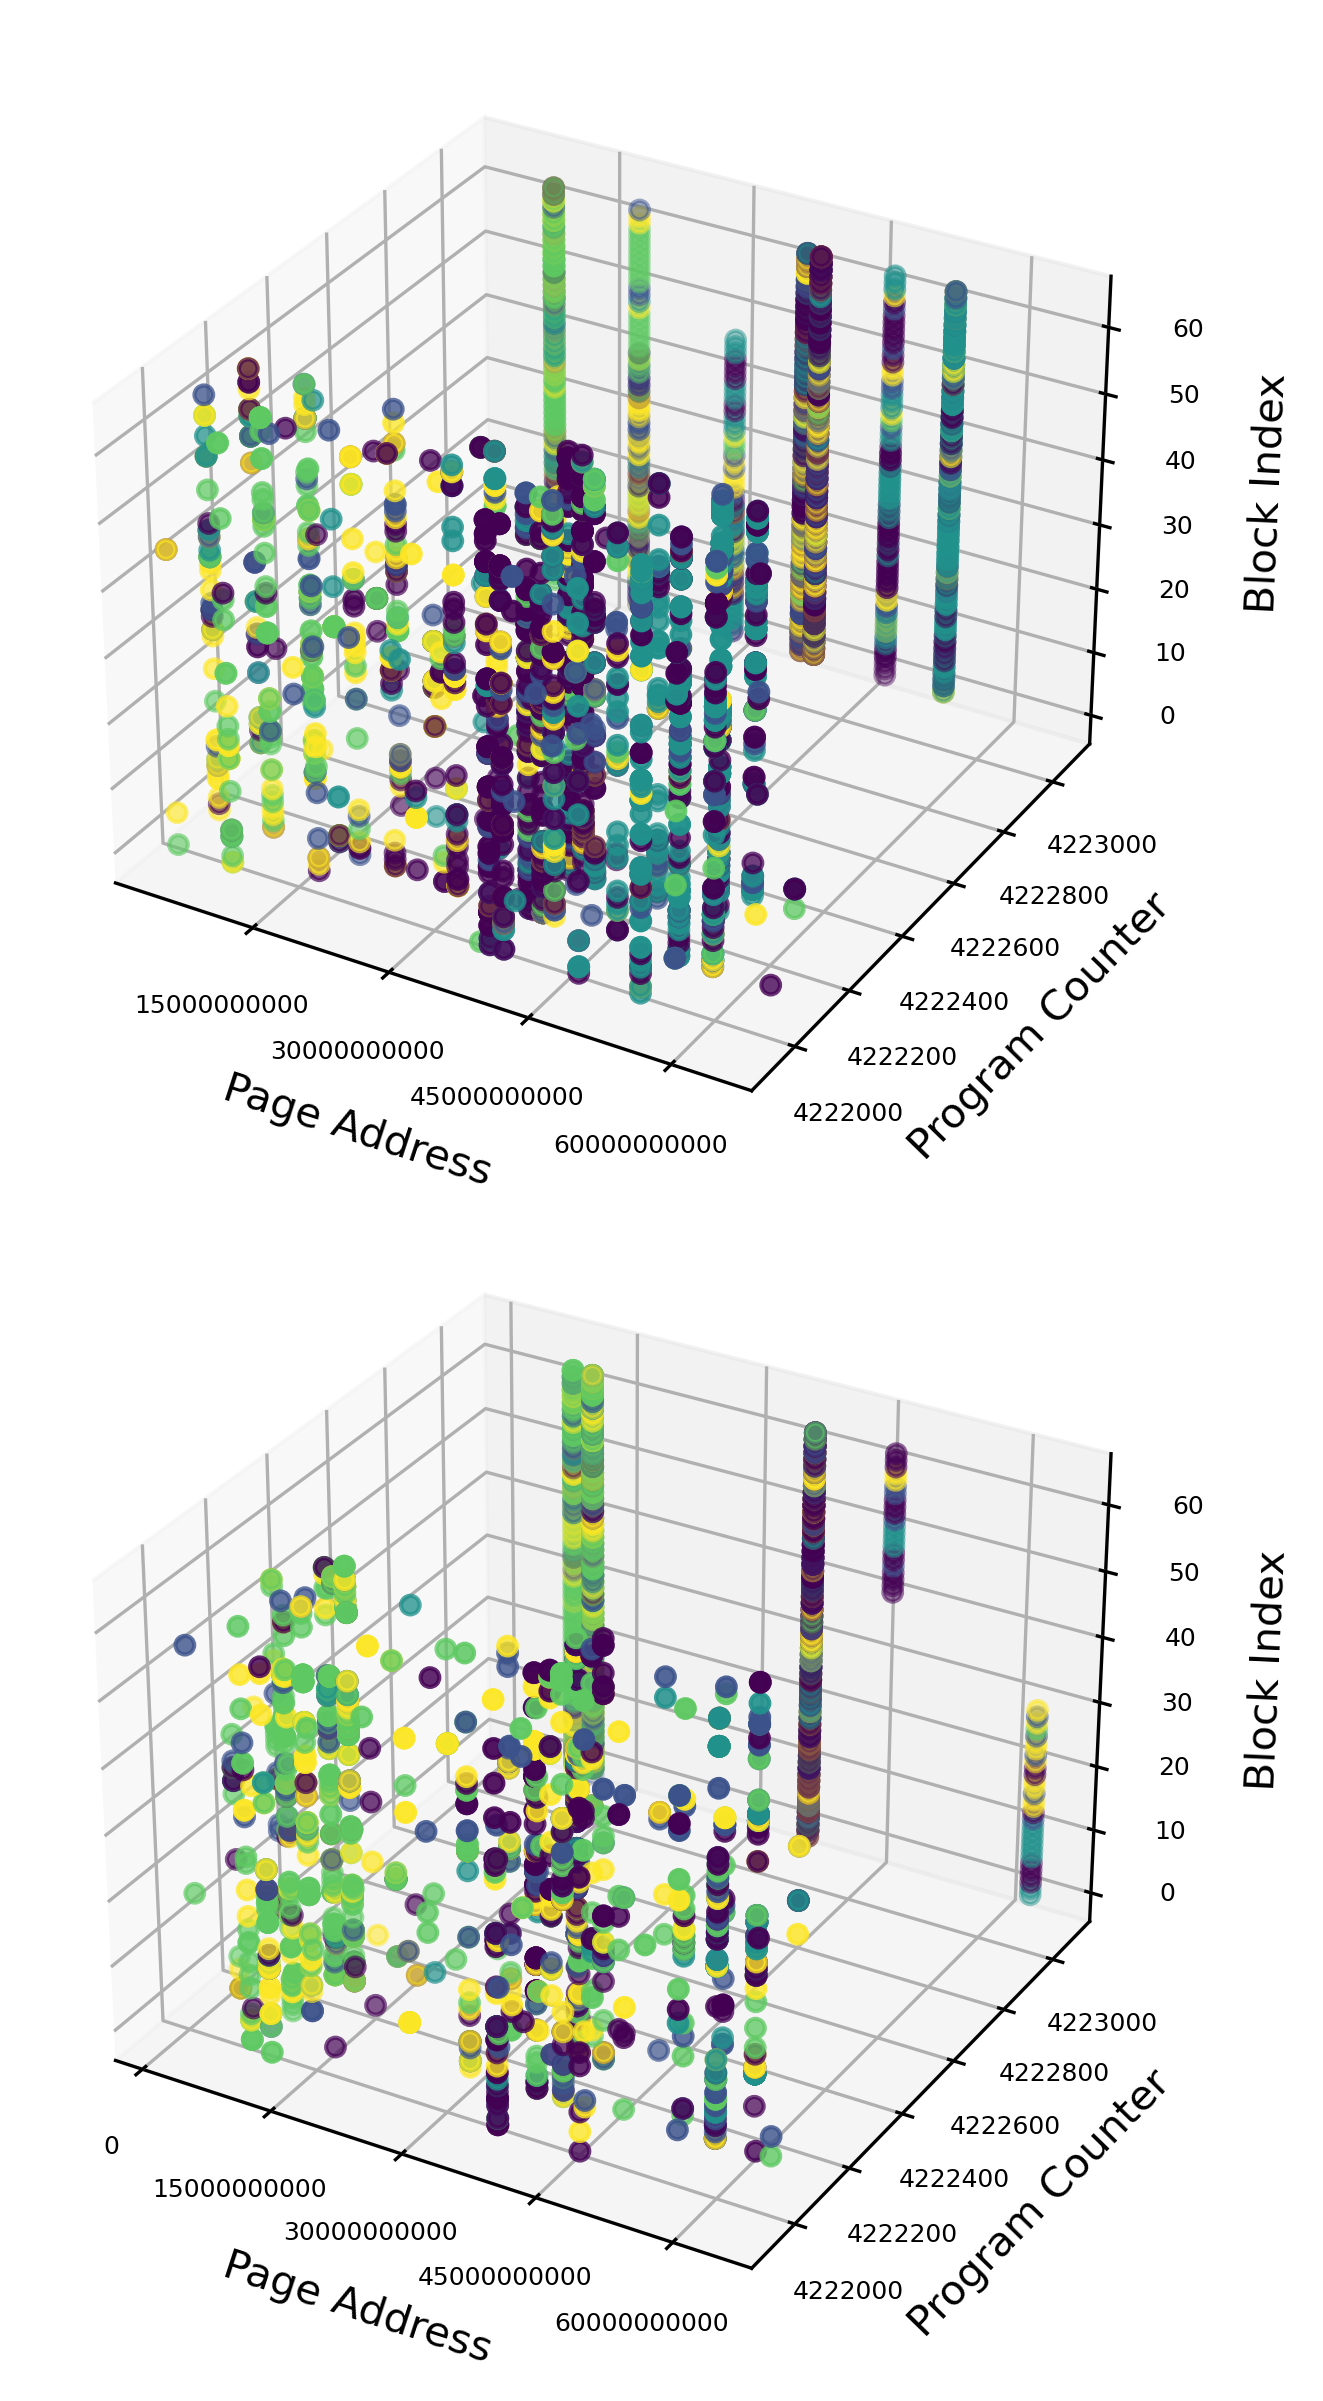

In [78]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import MaxNLocator

data_train = df_train['past_block_addr'].values
data_train = np.array(data_train.tolist())

data_test = df_test['past_block_addr'].values
data_test = np.array(data_test.tolist())

kmeans = KMeans(n_clusters=5, init='k-means++', random_state=0, n_init=10)

df_train['cluster'] = kmeans.fit_predict(data_train)
df_test['cluster'] = kmeans.predict(data_test)
fig = plt.figure(figsize=(5, 8), dpi=300)

ax_train = fig.add_subplot(211, projection='3d')
x_train = df_train['page_address']
y_train = df_train['ip']
z_train = df_train['block_index']
c_train = df_train['cluster']

ax_train.scatter3D(x_train, y_train, z_train, c=c_train)

ax_train.set_xlabel('Page Address')
ax_train.set_ylabel('Program Counter')
ax_train.set_zlabel('Block Index')
ax_train.yaxis.set_major_formatter('{:.0f}'.format)
ax_train.xaxis.set_major_formatter('{:.0f}'.format)
ax_train.tick_params(axis='both', which='major', labelsize=6)

ax_test = fig.add_subplot(212, projection='3d')

x_test = df_test['page_address']
y_test = df_test['ip']
z_test = df_test['block_index']
c_test = df_test['cluster']

ax_test.scatter3D(x_test, y_test, z_test, c=c_test)

ax_test.set_xlabel('Page Address')
ax_test.set_ylabel('Program Counter')
ax_test.set_zlabel('Block Index')
ax_test.yaxis.set_major_formatter('{:.0f}'.format)
ax_test.xaxis.set_major_formatter('{:.0f}'.format)
ax_test.tick_params(axis='both', which='major', labelsize=6)

ax_train.xaxis.set_major_locator(MaxNLocator(nbins=5))
ax_test.xaxis.set_major_locator(MaxNLocator(nbins=5))

plt.tight_layout()
plt.savefig('astar-past-delta.png', dpi=300)

plt.show()